In [ ]:
# --- Pre-Flight Script: Generate and Save the Sentinel Model and Scaler ---

# Step 1: Install necessary libraries
!pip install pandas numpy scikit-learn matplotlib tensorflow google-colab --quiet
print("--- Libraries installed ---")

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
import os
import glob
from tqdm.notebook import tqdm
import joblib
from collections import Counter

# --- 1. Setup ---
drive.mount('/content/drive')
DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Drift_Focused_Dataset'
BATCH_DIR_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'preprocessed_batches')
# Define the output paths for the files we need to create
MODEL_SAVE_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'autoencoder_anomaly_detector_v2.h5')
SCALER_SAVE_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'autoencoder_scaler_v2.joblib')

print(f"--- This script will generate models and save them to: ---")
print(f"Model: {MODEL_SAVE_PATH}")
print(f"Scaler: {SCALER_SAVE_PATH}")

batch_files = sorted(glob.glob(os.path.join(BATCH_DIR_PATH, 'batch_*.parquet')))
if not batch_files: raise FileNotFoundError("No batch files found.")

# --- 2. Get Training Patient IDs ---
# We only need the training IDs to train the model
patient_row_counts = Counter()
for file_path in tqdm(batch_files, desc="Counting Patient Rows"):
    df_temp = pd.read_parquet(file_path)
    patient_row_counts.update(df_temp.index.get_level_values('patient_id').value_counts().to_dict())
patient_counts_df = pd.DataFrame.from_dict(patient_row_counts, orient='index', columns=['row_count'])
available_patient_ids = patient_counts_df.index.values
patient_counts_df['duration_bin'] = pd.qcut(patient_counts_df['row_count'], q=5, labels=False, duplicates='drop')
train_ids, _ = train_test_split(
    available_patient_ids, test_size=0.2, random_state=42,
    stratify=patient_counts_df.loc[available_patient_ids, 'duration_bin']
)
train_ids_set = set(train_ids)

# --- 3. Fit Scaler on a Sample of Stable Data ---
print("\n--- Fitting scaler on a sample of stable data... ---")
stable_sample_chunks = []
total_stable_rows = 0
for file_path in tqdm(batch_files, desc="Sampling Stable Data"):
    df_chunk = pd.read_parquet(file_path).reset_index()
    train_chunk = df_chunk[df_chunk['patient_id'].isin(train_ids_set)].copy()
    if train_chunk.empty: continue

    train_chunk['BIS_future_30s'] = train_chunk.groupby('patient_id')['BIS/BIS'].shift(-30)
    train_chunk['BIS_drift_30s'] = train_chunk['BIS_future_30s'] - train_chunk['BIS/BIS']
    train_chunk.dropna(subset=['BIS_drift_30s'], inplace=True)
    DRIFT_THRESHOLD = 3.0
    train_chunk['drift_class'] = (train_chunk['BIS_drift_30s'].abs() > DRIFT_THRESHOLD).astype(int)

    stable_only_chunk = train_chunk[train_chunk['drift_class'] == 0]
    total_stable_rows += len(stable_only_chunk)

    X_train_chunk = stable_only_chunk.drop(columns=['BIS_drift_30s', 'BIS_future_30s', 'Time', 'patient_id', 'drift_class'])
    X_train_chunk.fillna(0, inplace=True)

    sample_fraction = 0.05
    stable_sample_chunks.append(X_train_chunk.sample(frac=sample_fraction, random_state=42))

X_train_sample = pd.concat(stable_sample_chunks)
print(f"Fitting scaler on {len(X_train_sample)} sampled rows.")
scaler = MinMaxScaler()
scaler.fit(X_train_sample)
joblib.dump(scaler, SCALER_SAVE_PATH)
print(f"Scaler saved successfully to {SCALER_SAVE_PATH}")
del X_train_sample, stable_sample_chunks

# --- 4. Data Generator for Training ---
def data_generator(batch_files, patient_ids, scaler, batch_size=512):
    while True:
        for file_path in batch_files:
            df_chunk = pd.read_parquet(file_path).reset_index()
            train_chunk = df_chunk[df_chunk['patient_id'].isin(patient_ids)].copy()
            if train_chunk.empty: continue

            train_chunk['BIS_future_30s'] = train_chunk.groupby('patient_id')['BIS/BIS'].shift(-30)
            train_chunk['BIS_drift_30s'] = train_chunk['BIS_future_30s'] - train_chunk['BIS/BIS']
            train_chunk.dropna(subset=['BIS_drift_30s'], inplace=True)
            DRIFT_THRESHOLD = 3.0
            train_chunk['drift_class'] = (train_chunk['BIS_drift_30s'].abs() > DRIFT_THRESHOLD).astype(int)

            stable_only_chunk = train_chunk[train_chunk['drift_class'] == 0]
            X_chunk = stable_only_chunk.drop(columns=['BIS_drift_30s', 'BIS_future_30s', 'Time', 'patient_id', 'drift_class'])
            X_chunk.fillna(0, inplace=True)

            if X_chunk.empty: continue

            X_scaled = scaler.transform(X_chunk)
            for i in range(0, len(X_scaled), batch_size):
                X_batch = X_scaled[i:i+batch_size]
                yield X_batch, X_batch

# --- 5. Build and Train Autoencoder ---
print("\n--- Building and Training the Autoencoder model... ---")
n_features = scaler.n_features_in_
model = keras.Sequential([
    keras.layers.Input(shape=(n_features,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(n_features, activation='sigmoid')
])
model.compile(optimizer='adam', loss='mae')
model.summary()

BATCH_SIZE = 512
STEPS_PER_EPOCH = int(np.ceil(total_stable_rows / BATCH_SIZE))

model.fit(
    data_generator(batch_files, train_ids_set, scaler, BATCH_SIZE),
    epochs=5,
    steps_per_epoch=STEPS_PER_EPOCH
)
model.save(MODEL_SAVE_PATH)
print(f"\n--- Autoencoder model saved successfully to {MODEL_SAVE_PATH} ---")
print("\n--- Pre-Flight Check Complete. You may now re-run the final hybrid script. ---")

--- Libraries installed ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- This script will generate models and save them to: ---
Model: /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/autoencoder_anomaly_detector_v2.h5
Scaler: /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/autoencoder_scaler_v2.joblib


Counting Patient Rows:   0%|          | 0/31 [00:00<?, ?it/s]


--- Fitting scaler on a sample of stable data... ---


Sampling Stable Data:   0%|          | 0/31 [00:00<?, ?it/s]

Fitting scaler on 635233 sampled rows.
Scaler saved successfully to /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/autoencoder_scaler_v2.joblib

--- Building and Training the Autoencoder model... ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 42)             │         2,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,356 (40.45 KB)

 Trainable params: 10,356 (40.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
24814/24814 ━━━━━━━━━━━━━━━━━━━━ 124s 5ms/step - loss: 0.0304
Epoch 2/5
24814/24814 ━━━━━━━━━━━━━━━━━━━━ 125s 5ms/step - loss: 0.0190
Epoch 3/5
24814/24814 ━━━━━━━━━━━━━━━━━━━━ 120s 5ms/step - loss: 0.0168
Epoch 4/5
24814/24814 ━━━━━━━━━━━━━━━━━━━━ 119s 5ms/step - loss: 0.0158
Epoch 5/5
24814/24814 ━━━━━━━━━━━━━━━━━━━━ 119s 5ms/step - loss: 0.0155



--- Autoencoder model saved successfully to /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/autoencoder_anomaly_detector_v2.h5 ---

--- Pre-Flight Check Complete. You may now re-run the final hybrid script. ---


In [ ]:
# --- The Final, Hybrid Architecture: Autoencoder Sentinel + LightGBM Specialist ---

# Step 1: Install necessary libraries
!pip install lightgbm pandas numpy scikit-learn matplotlib tensorflow google-colab --quiet
print("--- Libraries installed ---")

import pandas as pd
import numpy as np
import lightgbm as lgb
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
import os
import glob
from tqdm.notebook import tqdm
import joblib
import warnings
from collections import Counter

# Suppress warnings for cleaner output
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=UserWarning, module='lightgbm')

# --- 1. Setup and Configuration ---
print("--- Setting up paths and loading models... ---")
drive.mount('/content/drive')
DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Drift_Focused_Dataset'
BATCH_DIR_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'preprocessed_batches')

# --- Paths to our PRE-TRAINED models ---
AUTOENCODER_MODEL_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'autoencoder_anomaly_detector_v2.h5')
SCALER_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'autoencoder_scaler_v2.joblib')
SPECIALIST_MODEL_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'final_lgbm_ros_classifier_v8.joblib')

# --- Load the models ---
try:
    # FIX: Explicitly define 'mae' as a custom object for loading
    sentinel_model = tf.keras.models.load_model(
        AUTOENCODER_MODEL_PATH,
        custom_objects={'mae': tf.keras.losses.MeanAbsoluteError()}
    )
    scaler = joblib.load(SCALER_PATH)
    specialist_model = joblib.load(SPECIALIST_MODEL_PATH)
    print("Successfully loaded Sentinel (Autoencoder) and Specialist (LightGBM) models.")
except Exception as e:
    # Re-raise the error if loading fails for any other reason
    raise FileNotFoundError(f"Could not load one or more pre-trained models. Error: {e}")

# --- Anomaly Threshold (determined from Path 3's analysis) ---
ANOMALY_THRESHOLD = 0.006323
print(f"Using anomaly threshold: {ANOMALY_THRESHOLD}")

# --- 2. Get Validation Patient IDs ---
print("\n--- Getting consistent Validation Patient IDs ---")
batch_files = sorted(glob.glob(os.path.join(BATCH_DIR_PATH, 'batch_*.parquet')))
if not batch_files: raise FileNotFoundError("No batch files found.")

patient_row_counts = Counter()
for file_path in tqdm(batch_files, desc="Counting Patient Rows"):
    df_temp = pd.read_parquet(file_path)
    patient_row_counts.update(df_temp.index.get_level_values('patient_id').value_counts().to_dict())

patient_counts_df = pd.DataFrame.from_dict(patient_row_counts, orient='index', columns=['row_count'])
available_patient_ids = patient_counts_df.index.values
patient_counts_df['duration_bin'] = pd.qcut(patient_counts_df['row_count'], q=5, labels=False, duplicates='drop')
_, val_ids = train_test_split(
    available_patient_ids, test_size=0.2, random_state=42,
    stratify=patient_counts_df.loc[available_patient_ids, 'duration_bin']
)
val_ids_set = set(val_ids)
print(f"Identified {len(val_ids_set)} validation patients.")


# --- 3. The Hybrid Prediction Pipeline ---
print("\n--- Predicting on Validation Set using the Hybrid Pipeline... ---")
all_final_preds = []
all_y_val = []

for file_path in tqdm(batch_files, desc="Predicting on Batches"):
    df_chunk = pd.read_parquet(file_path).reset_index()
    val_chunk = df_chunk[df_chunk['patient_id'].isin(val_ids_set)].copy()
    if val_chunk.empty: continue

    # --- Feature and Target Engineering ---
    val_chunk['BIS_future_30s'] = val_chunk.groupby('patient_id')['BIS/BIS'].shift(-30)
    val_chunk['BIS_drift_30s'] = val_chunk['BIS_future_30s'] - val_chunk['BIS/BIS']
    val_chunk.dropna(subset=['BIS_drift_30s'], inplace=True)

    DRIFT_THRESHOLD = 3.0
    val_chunk['drift_class'] = 0
    val_chunk.loc[val_chunk['BIS_drift_30s'] > DRIFT_THRESHOLD, 'drift_class'] = 1
    val_chunk.loc[val_chunk['BIS_drift_30s'] < -DRIFT_THRESHOLD, 'drift_class'] = 2

    X_val_chunk = val_chunk.drop(columns=['BIS_drift_30s', 'BIS_future_30s', 'Time', 'patient_id', 'drift_class'])
    y_val_chunk = val_chunk['drift_class']
    X_val_chunk.fillna(0, inplace=True)

    if X_val_chunk.empty: continue

    # --- STAGE 1: SENTINEL PREDICTION (AUTOENCODER) ---
    X_val_scaled = scaler.transform(X_val_chunk)
    reconstructions = sentinel_model.predict(X_val_scaled, verbose=0, batch_size=2048)
    errors = np.mean(np.abs(X_val_scaled - reconstructions), axis=1)

    unstable_indices = np.where(errors > ANOMALY_THRESHOLD)[0]

    # --- STAGE 2: SPECIALIST PREDICTION (LIGHTGBM) ---
    final_preds = np.zeros(len(X_val_chunk), dtype=int)

    if len(unstable_indices) > 0:
        X_val_unstable = X_val_chunk.iloc[unstable_indices]
        preds_specialist_proba = specialist_model.predict(X_val_unstable)
        final_specialist_preds = np.argmax(preds_specialist_proba, axis=1)
        final_preds[unstable_indices] = final_specialist_preds

    all_final_preds.append(final_preds)
    all_y_val.append(y_val_chunk)

# --- 4. Final Evaluation ---
print("\n--- Final Evaluation of the Hybrid Model ---")
y_val_computed = pd.concat(all_y_val)
final_preds_computed = np.concatenate(all_final_preds)

print(f"Successfully processed {len(y_val_computed)} validation samples.")
print("\n--- Classification Report (Hybrid Model) ---")
print(classification_report(y_val_computed, final_preds_computed, target_names=['Stable', 'Drifting Up', 'Drifting Down']))

--- Libraries installed ---
--- Setting up paths and loading models... ---


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully loaded Sentinel (Autoencoder) and Specialist (LightGBM) models.
Using anomaly threshold: 0.006323

--- Getting consistent Validation Patient IDs ---


Counting Patient Rows:   0%|          | 0/31 [00:00<?, ?it/s]

Identified 542 validation patients.

--- Predicting on Validation Set using the Hybrid Pipeline... ---


Predicting on Batches:   0%|          | 0/31 [00:00<?, ?it/s]


--- Final Evaluation of the Hybrid Model ---
Successfully processed 5398570 validation samples.

--- Classification Report (Hybrid Model) ---
               precision    recall  f1-score   support

       Stable       0.71      0.41      0.52   3150417
  Drifting Up       0.37      0.53      0.43   1150286
Drifting Down       0.35      0.61      0.45   1097867

     accuracy                           0.48   5398570
    macro avg       0.48      0.52      0.47   5398570
 weighted avg       0.56      0.48      0.49   5398570


--- Confusion Matrix (Hybrid Model) ---


NameError: name 'plt' is not defined


--- Confusion Matrix (Hybrid Model) ---


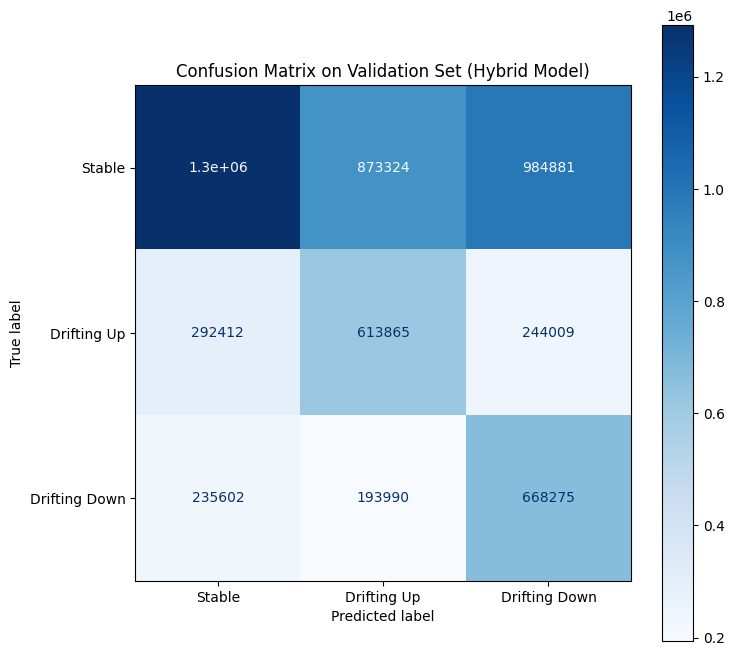

In [ ]:
import matplotlib.pyplot as plt
print("\n--- Confusion Matrix (Hybrid Model) ---")
cm = confusion_matrix(y_val_computed, final_preds_computed)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stable', 'Drifting Up', 'Drifting Down'])
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix on Validation Set (Hybrid Model)")
plt.show()